
# Case Fictício – Simulação, Otimização e IA (Volkswagen)
## Planejamento de Testes Veiculares

Este notebook demonstra:
1. Geração de dados sintéticos  
2. Modelo preditivo de falhas (Machine Learning)  
3. Simulação Monte Carlo  
4. Otimização de agendamento de testes (PuLP)  

> **Observação:** Todos os dados são fictícios e usados apenas para fins demonstrativos.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, confusion_matrix

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Geração de dados sintéticos

In [ ]:

np.random.seed(42)

n_tests = 200

df_tests = pd.DataFrame({
    'test_id': range(n_tests),
    'duration': np.random.normal(120, 30, n_tests).clip(30),
    'priority': np.random.randint(1, 6, n_tests),
    'complexity': np.random.randint(1, 4, n_tests),
    'environment_temp': np.random.normal(25, 5, n_tests)
})


raw = 0.25 * df_tests['complexity'] + 0.05 * (df_tests['duration']/60) + 0.03 * abs(df_tests['environment_temp'] - 25)
df_tests['true_prob'] = (raw - raw.min()) / (raw.max() - raw.min()) * 0.8  # escala entre 0 e 0.8
df_tests['failure'] = np.random.binomial(1, df_tests['true_prob'])



df_tests.head()


,test_id,duration,priority,complexity,environment_temp,true_prob,failure
0,0,134.901425,2,1,7.609154,0.491076,1
1,1,115.852071,2,3,23.658685,0.493363,1
2,2,139.430656,1,1,22.410439,0.109567,0
3,3,165.690896,1,1,29.464127,0.177262,0
4,4,112.975399,1,3,22.183707,0.529630,0


## Modelo preditivo de falhas

In [3]:

features = ['duration', 'priority', 'complexity', 'environment_temp']
X = df_tests[features]
y = df_tests['failure']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, probs)
brier = brier_score_loss(y_test, probs)

auc, brier


(0.6752246469833119, 0.20667400618779375)

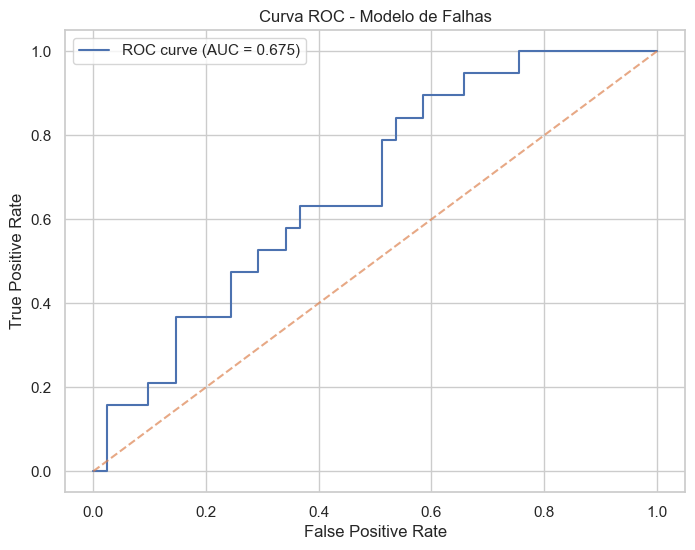

AUC: 0.6752
Brier score: 0.2067


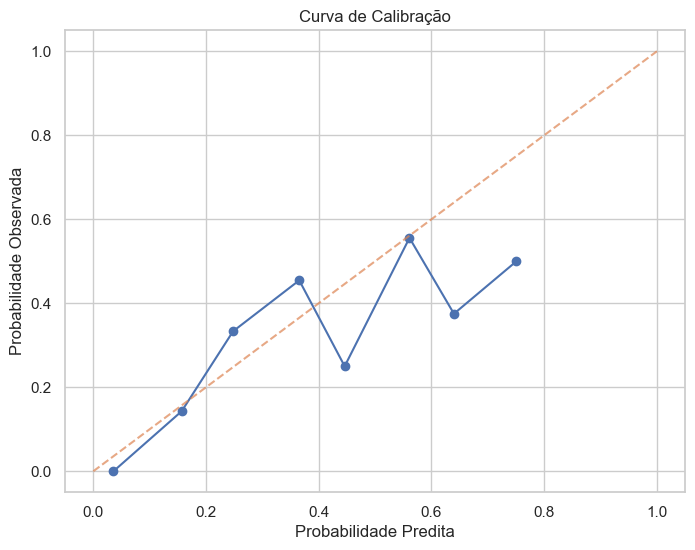

In [ ]:

#  Curva ROC e Avaliação (AUC, Brier)
from sklearn.metrics import roc_curve, auc, brier_score_loss
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
brier = brier_score_loss(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo de Falhas')
plt.legend()
plt.show()

print(f'AUC: {roc_auc:.4f}')
print(f'Brier score: {brier:.4f}')

# Curva de calibração 
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--', alpha=0.7)
plt.xlabel('Probabilidade Predita')
plt.ylabel('Probabilidade Observada')
plt.title('Curva de Calibração')
plt.show()



**Interpretação:**  
- AUC indica capacidade de discriminar testes com maior risco de falha.  
- Brier score avalia a calibração das probabilidades previstas.


# Visualização da Performance do Modelo

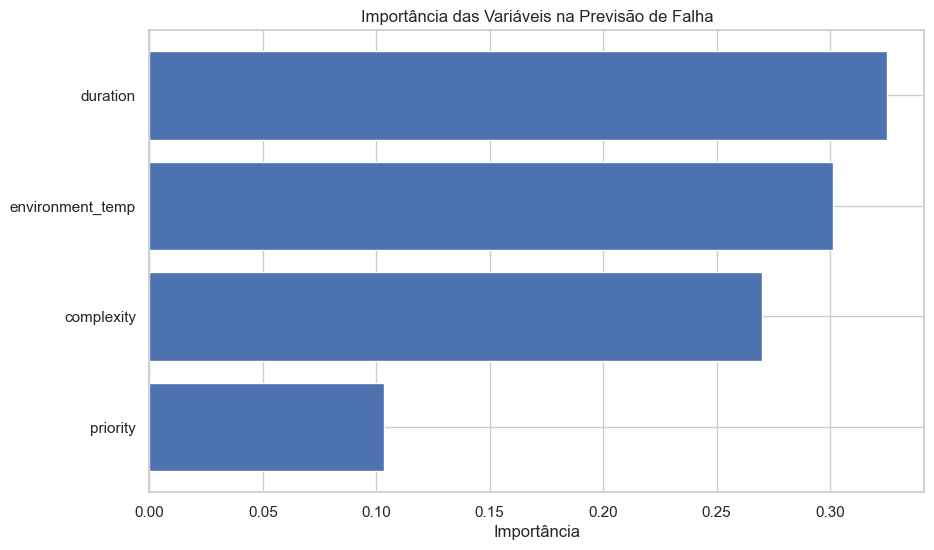

In [12]:
#  Feature Importance
importances = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importances = importances.sort_values('importance')

plt.barh(importances['feature'], importances['importance'])
plt.xlabel('Importância')
plt.title('Importância das Variáveis na Previsão de Falha')
plt.show()


# Preparação para Otimização

In [7]:
# Aplicar o modelo em TODO o dataset para o cenário de otimização
df_tests['prob_failure'] = model.predict_proba(df_tests[features])[:, 1]

# Definir um tempo de reparo médio (ex: 60 min se falhar)
REPAIR_TIME = 60

# Calcular Duração Esperada = Duração Teste + (Prob. Falha * Tempo Reparo)
# Isso penaliza testes arriscados, fazendo o otimizador alocá-los com mais inteligência
df_tests['expected_duration'] = df_tests['duration'] + (df_tests['prob_failure'] * REPAIR_TIME)

print("Exemplo de ajuste de risco:")
print(df_tests[['test_id', 'duration', 'prob_failure', 'expected_duration']].head())

Exemplo de ajuste de risco:
   test_id    duration  prob_failure  expected_duration
0        0  134.901425      0.623079         172.286153
1        1  115.852071      0.651148         154.920935
2        2  139.430656      0.080813         144.279441
3        3  165.690896      0.187161         176.920575
4        4  112.975399      0.349787         133.962636


##  Problema de otimização (agendamento simplificado)


Objetivo:
- Minimizar o tempo total ponderado pela prioridade e risco de falha.

Restrições:
- Apenas uma baia de teste
- Testes executados sequencialmente


In [ ]:
#  Otimização com Múltiplas Baias ---

def optimize_multi_bay(df, n_bays=3):
    # Criar o problema: Minimizar o Makespan (o tempo da baia que termina por último)
    prob = pulp.LpProblem("Multi_Bay_Scheduling", pulp.LpMinimize)
    
    # Variáveis de decisão: x[i][j] = 1 se o teste i for alocado na baia j
    # Usamos índices inteiros para facilitar
    tests = df.index.tolist()
    bays = range(n_bays)
    
    x = pulp.LpVariable.dicts("assign", (tests, bays), cat='Binary')
    
    # Variável auxiliar para o Makespan (Cmax)
    Cmax = pulp.LpVariable("Makespan", lowBound=0)
    
    # Função Objetivo: Minimizar o Makespan
    prob += Cmax
    
    # Restrição 1: Cada teste deve ser alocado a exatamente uma baia
    for i in tests:
        prob += pulp.lpSum([x[i][j] for j in bays]) == 1
        
    # Restrição 2: O tempo total de cada baia não pode exceder Cmax
    # Usamos a 'expected_duration' que criamos com a IA
    for j in bays:
        prob += pulp.lpSum([x[i][j] * df.loc[i, 'expected_duration'] for i in tests]) <= Cmax
        
    # Restrição de Balanceamento de Prioridade:

    # Resolver
    prob.solve(pulp.PULP_CBC_CMD(msg=1, timeLimit=60, gapRel=0.05))
    
    # Recuperar resultados
    results = []
    for i in tests:
        for j in bays:
            if pulp.value(x[i][j]) > 0.5:
                results.append({
                    'test_id': df.loc[i, 'test_id'],
                    'bay': j,
                    'duration_actual': df.loc[i, 'duration'],
                    'duration_risk': df.loc[i, 'expected_duration'],
                    'priority': df.loc[i, 'priority']
                })
                
    return pd.DataFrame(results), pulp.value(Cmax)

# Executar a otimização
df_scheduled, final_makespan = optimize_multi_bay(df_tests, n_bays=3)

print(f"Makespan Otimizado (Tempo total estimado): {final_makespan:.2f} minutos")
df_scheduled.head()

Makespan Otimizado (Tempo total estimado): 9386.62 minutos


,test_id,bay,duration_actual,duration_risk,priority
0,0,0,134.901425,172.286153,2
1,1,0,115.852071,154.920935,2
2,2,0,139.430656,144.279441,1
3,3,1,165.690896,176.920575,1
4,4,0,112.975399,133.962636,1


##  Simulação Monte Carlo de durações

Iniciando 2000 simulações de Monte Carlo...


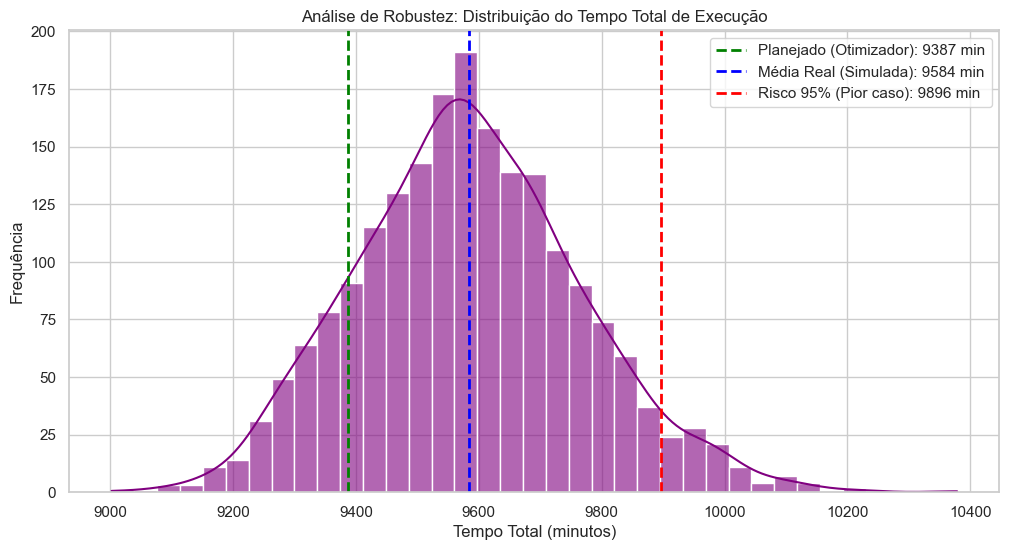

Conclusão da Simulação:
O otimizador estimou 9387 min.
Na prática (média), levará 9584 min.
Existe 5% de chance de ultrapassar 9896 min.


In [ ]:
# Validação via Simulação de Monte Carlo 

def validate_schedule_robustness(schedule_df, n_simulations=1000, repair_time=60):
    """
    Simula a execução do cronograma definido milhares de vezes para
    avaliar o risco de atrasos reais.
    """
    makespans = []
    
    # Agrupa quais testes estão em qual baia (conforme decidido pelo otimizador)
    bays_allocation = schedule_df.groupby('bay')['test_id'].apply(list).to_dict()
    
    # Dicionário para acesso rápido aos parâmetros originais
    # Aqui usamos os dados originais para simular a 'Realidade'
    original_data = df_tests.set_index('test_id')
    
    print(f"Iniciando {n_simulations} simulações de Monte Carlo...")
    
    for _ in range(n_simulations):
        bay_completion_times = []
        
        # Para cada baia, calculamos quanto tempo ela realmente levou nessa simulação
        for bay, tests in bays_allocation.items():
            bay_total_time = 0
            
            for tid in tests:
                # 1. Incerteza Natural: A duração varia um pouco (Desvio Padrão de 15%)
                base_duration = np.random.normal(
                    original_data.loc[tid, 'duration'], 
                    original_data.loc[tid, 'duration'] * 0.15
                )
                base_duration = max(20, base_duration) # Garante que não seja negativo/muito curto
                
                # 2. Evento de Falha: Joga-se a moeda com base na probabilidade prevista
                # Se falhar, adiciona o tempo de reparo
                prob_failure = original_data.loc[tid, 'prob_failure']
                failure_event = np.random.binomial(1, prob_failure)
                
                actual_duration = base_duration + (failure_event * repair_time)
                bay_total_time += actual_duration
            
            bay_completion_times.append(bay_total_time)
        
        # O tempo total do projeto (Makespan) é determinado pela baia que terminar por último
        makespans.append(max(bay_completion_times))
        
    return makespans

# Executar a validação
# 'df_scheduled' é o DataFrame que saiu da etapa de Otimização (Pulp)
simulated_makespans = validate_schedule_robustness(df_scheduled, n_simulations=2000)

# --- Visualização dos Resultados da Simulação ---
plt.figure(figsize=(12, 6))
sns.histplot(simulated_makespans, kde=True, color='purple', alpha=0.6)

# Linhas de referência
mean_time = np.mean(simulated_makespans)
p95_time = np.percentile(simulated_makespans, 95)
planned_time = final_makespan # O valor que o otimizador prometeu

plt.axvline(planned_time, color='green', linestyle='--', linewidth=2, label=f'Planejado (Otimizador): {planned_time:.0f} min')
plt.axvline(mean_time, color='blue', linestyle='--', linewidth=2, label=f'Média Real (Simulada): {mean_time:.0f} min')
plt.axvline(p95_time, color='red', linestyle='--', linewidth=2, label=f'Risco 95% (Pior caso): {p95_time:.0f} min')

plt.title('Análise de Robustez: Distribuição do Tempo Total de Execução')
plt.xlabel('Tempo Total (minutos)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

print(f"Conclusão da Simulação:")
print(f"O otimizador estimou {planned_time:.0f} min.")
print(f"Na prática (média), levará {mean_time:.0f} min.")
print(f"Existe 5% de chance de ultrapassar {p95_time:.0f} min.")

# Visualização do Agendamento (Gantt)

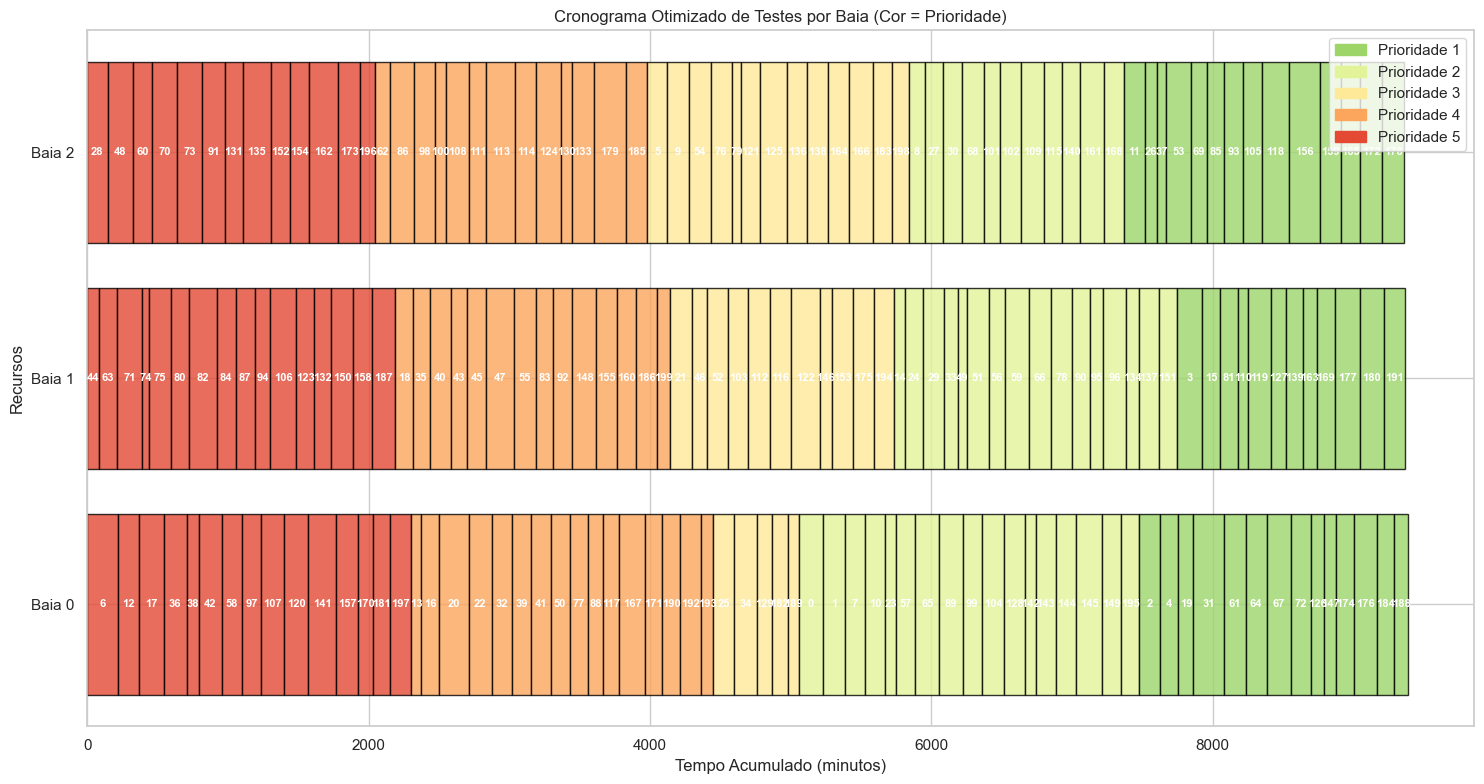

In [ ]:
#  Gráfico de Gantt

def plot_gantt(df_sched):
    # Ordenar por baia e prioridade
    df_sched = df_sched.sort_values(by=['bay', 'priority'], ascending=[True, False])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Paleta de 6 cores (índices 0 a 5). 
    # Como prioridade vai de 1 a 5, usaremos os índices 1 a 5.
    colors = sns.color_palette("RdYlGn_r", 6) 
    
    for bay in df_sched['bay'].unique():
        bay_data = df_sched[df_sched['bay'] == bay]
        current_time = 0
        
        for _, row in bay_data.iterrows():
            # CORREÇÃO AQUI: int(row['priority'])
            # Forçamos o valor a ser inteiro para usar como índice da lista de cores
            priority_idx = int(row['priority'])
            
            ax.barh(
                y=f"Baia {bay}", 
                width=row['duration_risk'], 
                left=current_time, 
                color=colors[priority_idx], 
                edgecolor='black',
                alpha=0.8
            )
            
            # Texto dentro da barra
            if row['duration_risk'] > 20:
                ax.text(
                    current_time + row['duration_risk']/2, 
                    bay, 
                    str(int(row['test_id'])), # Também convertemos ID para int para ficar bonito (ex: "10" e não "10.0")
                    ha='center', va='center', color='white', fontsize=8, weight='bold'
                )
            
            current_time += row['duration_risk']
            
    plt.title('Cronograma Otimizado de Testes por Baia (Cor = Prioridade)')
    plt.xlabel('Tempo Acumulado (minutos)')
    plt.ylabel('Recursos')
    
    # Legenda customizada
    patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(1, 6)]
    plt.legend(patches, [f'Prioridade {i}' for i in range(1, 6)], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_gantt(df_scheduled)

# Simulação Final (Robustez)

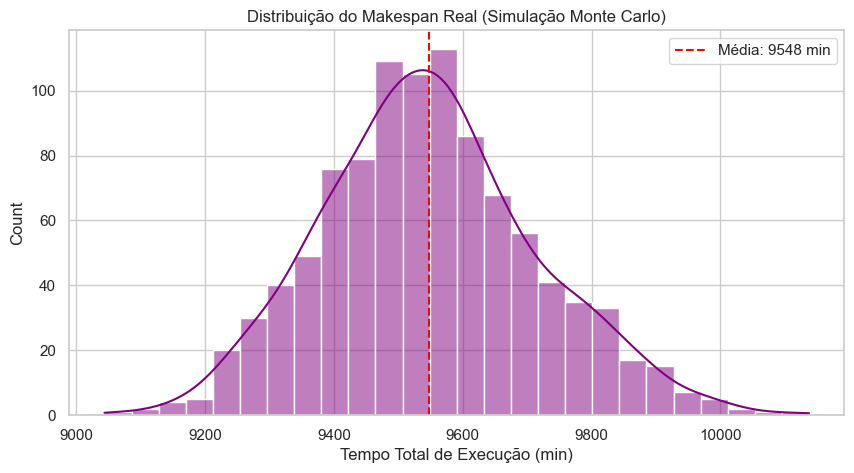

In [ ]:
# Validação via Monte Carlo ---

def simulate_schedule_execution(schedule_df, n_simulations=1000):
    makespans = []
    
    # Agrupar testes por baia conforme definido pelo otimizador
    bays_allocation = schedule_df.groupby('bay')['test_id'].apply(list).to_dict()
    
    # Dicionário auxiliar para buscar dados reais rapidamente
    original_data = df_tests.set_index('test_id')
    
    for _ in range(n_simulations):
        bay_times = []
        
        for bay, tests in bays_allocation.items():
            total_time = 0
            for tid in tests:
                # 1. Variabilidade natural da duração (Normal)
                base_duration = np.random.normal(
                    original_data.loc[tid, 'duration'], 
                    original_data.loc[tid, 'duration'] * 0.1
                )
                
                # 2. Ocorrência de Falha (Binomial baseada na prob real oculta ou do modelo)
                # Vamos usar a prob do modelo para ser justo com o planejador
                is_fail = np.random.binomial(1, original_data.loc[tid, 'prob_failure'])
                
                actual_duration = base_duration + (is_fail * 60) # 60 min de reparo
                total_time += actual_duration
            
            bay_times.append(total_time)
        
        # O makespan da simulação é a baia que demorou mais
        makespans.append(max(bay_times))
        
    return makespans

sim_results = simulate_schedule_execution(df_scheduled)

plt.figure(figsize=(10, 5))
sns.histplot(sim_results, kde=True, color='purple')
plt.axvline(np.mean(sim_results), color='red', linestyle='--', label=f'Média: {np.mean(sim_results):.0f} min')
plt.title('Distribuição do Makespan Real (Simulação Monte Carlo)')
plt.xlabel('Tempo Total de Execução (min)')
plt.legend()
plt.show()